# Introducció a OpenCV


En aquesta pràctica veurem algunes utilitats pràctiques d'OpenCV, centrant-nos el processat d'imatges.

Com a exemple anem a extreure la linea (feta en cinta dhesiva negra) del terra. Extreure la linea del terra és un problema clàssic en robòtica mòbil, ja que és una de les referències més importants per a la navegació

## Procediment

Instalem les llibreries necessàries


In [57]:
%pip install matplotlib opencv-python-headless

Note: you may need to restart the kernel to use updated packages.


Carreguem les llibreries necessàries per a la pràctica.

In [58]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Carregant imatges

Quan carreguem imatges en opencv es sol utilitzar una representació com a arrays de NumPy; una dimensió per color.

D'aquesta manera, una imatge en B/N de `542X959` s'enmagatzemarà en un array de `542X959` i si és en color en un array `542X959x3`.


Carreguem la imatge inicial:


(542, 959, 3)


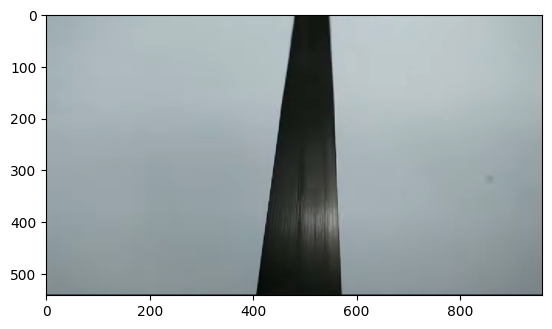

In [59]:
im = cv2.imread("line.png")
print(im.shape)
plt.imshow(im)

Per planificar el següent pas el robot solament necessita la informació de la linea inferior de la imatge. Per això, es pot tallar la imatge per a que solament es processi la part inferior.

Com que la imatge està en format de matriu, es pot fer servir la notació de `slicing` de NumPy per a tallar la imatge. Això es fa amb la notació `img[y1:y2, x1:x2]` on `y1` i `y2` són les coordenades verticals i `x1` i `x2` les horitzontals.

La imatge original té una mida de `542x959` i volem tallar la part inferior de la imatge, per tant, volem deixar la part de la imatge que va des de la fila `200` fins a la `542` i des de la columna `0` fins a la `959`.

(342, 959, 3)


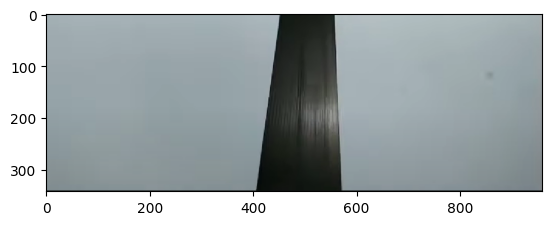

In [60]:
im_baix = im[200:959, 0:959]
print(im_baix.shape)
plt.imshow(im_baix)

### Processem la imatge

Per fer el seguiment de la linea del terra, primer hem de convertir la imatge a escala de grisos. Això ho podem fer amb la funció `cv2.cvtColor`.

(342, 959)


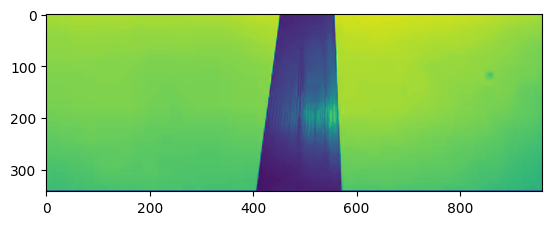

In [61]:
im_bn = cv2.cvtColor(im_baix, cv2.COLOR_BGR2GRAY)
print(im_bn.shape)
plt.imshow(im_bn)

La imatge en escala de grisos és una imatge en la que cada píxel té un valor entre 0 i 255, on 0 és negre i 255 és blanc. Això ens permet treballar amb una sola dimensió i simplificar el processat de la imatge.

Es mostra en colors per a que es vegi millor, però el processat es farà en escala de grisos.


Aplicarem un GaussianBlur per a suavitzar la imatge i eliminar el soroll. Això ho podem fer amb la funció `cv2.GaussianBlur`.

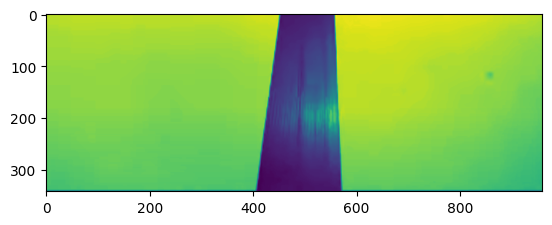

In [62]:
im_blurred = cv2.GaussianBlur(im_bn, (5, 5), 0)
plt.imshow(im_blurred)

### Thresolding

A continuació farem _thresolding_ (separar el fons del primer plà). En aquest [article](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html) podem veure ben descrit el procediment.

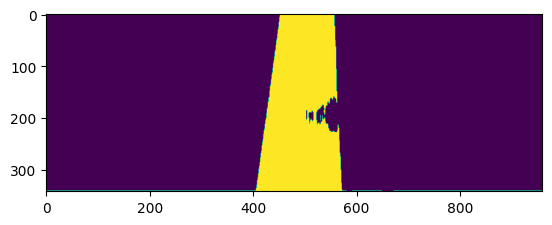

In [63]:
ret, im_th = cv2.threshold(im_blurred,100,255,cv2.THRESH_BINARY_INV)
plt.imshow(im_th)

El mètode més senzill és el _Simple Thresholding_ que simplement compara cada pixel amb un valor i el converteix en blanc o negre segons si és més gran o més petit. Aquest mètode és el més senzill i el més ràpid. Aquest mètode es pot fer servir quan la imatge està ben il·luminada i el fons és fàcil de separar del primer plà.

En el nostre cas hem marcat el valor de _threshold_ a 100, però es pot ajustar segons la imatge.

### Búsqueda de vores

Un cop tenim la imatge binaritzada, podem buscar les vores de la linea. Això ho podem fer amb la funció `cv2.findContours`. Aquesta funció retorna una llista de vores, que són una llista de punts que formen la vora.

Com aquesta funció transforma la imatge, farem una còpia de la imatge binaritzada per a no perdre la imatge original.

In [64]:
im_th_copy = im_th.copy()
contours, _ = cv2.findContours(im_th_copy, 1, cv2.CHAIN_APPROX_NONE)

Com que solament ens interessa la vora més gran, verificarem si hi ha més d'una vora i ens quedarem amb la més gran.

Una vegada trobada la vora buscarem el centre de la vora. Això ho podem fer amb la funció `cv2.moments`. Aquesta funció retorna un diccionari amb els moments de la imatge, que ens permeten calcular el centre de la vora. Concretament: `cX = M["m10"] / M["m00"]` i `cY = M["m01"] / M["m00"]`.

### Dibuixem la vora

Finalment, dibuixarem la vora en la imatge original. Això ho podem fer amb la funció `cv2.drawContours` i `cv2.circle` per a dibuixar el centre de la vora.

493 183


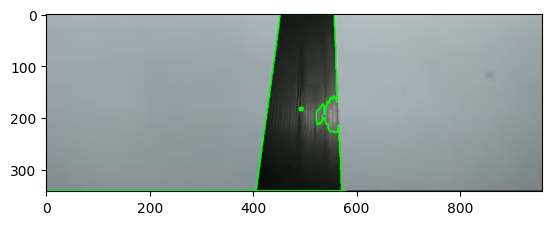

In [65]:
if len(contours) != 0:
    max_contour = max(contours, key = cv2.contourArea)
    center = cv2.moments(max_contour)
    cx = int(center['m10']/center['m00'])
    cy = int(center['m01']/center['m00'])
    print(cx, cy)
    
    cv2.circle(im_baix, (cx, cy), 5,  (0, 255, 0), -1) # 
    cv2.drawContours(im_baix, [max_contour], 0, (0, 255, 0), 2)
    plt.imshow(im_baix)

Per finalitzar simulem el moviment del robot, fent que si el centre de la vora està a la dreta del centre de la imatge 
més d'un cert valor, la vora es mostre de color vermell, i si està a l'esquerra, de color blau.

També agruparem tot el codi en una funció `process_image` que rebrà la imatge com a paràmetre i retornarà la imatge processada.

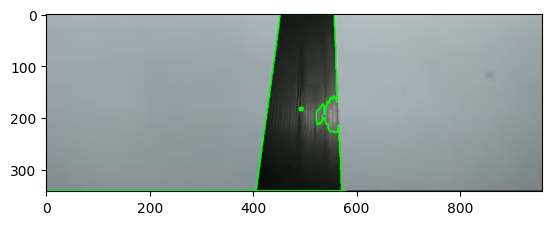

In [66]:
def process_image(im):
    im_baix = im[200:959, 0:959]
    im_bn = cv2.cvtColor(im_baix, cv2.COLOR_BGR2GRAY)
    im_blurred = cv2.GaussianBlur(im_bn, (5, 5), 0)
    ret, im_th = cv2.threshold(im_blurred,100,255,cv2.THRESH_BINARY_INV)
    im_th_copy = im_th.copy()
    contours, _ = cv2.findContours(im_th_copy, 1, cv2.CHAIN_APPROX_NONE)
    if len(contours) != 0:
        max_contour = max(contours, key = cv2.contourArea)
        center = cv2.moments(max_contour)
        cx = int(center['m10']/center['m00'])
        cy = int(center['m01']/center['m00'])

        color = (0, 255, 0)

        if cx < 300:
            color = (0, 0, 255)
        elif cx > 600:
            color = (255, 0, 0)

        cv2.circle(im_baix, (cx, cy), 5,  color, -1)
        cv2.drawContours(im_baix, [max_contour], 0, color, 2)

    return im_baix

im = cv2.imread("line.png")
im_proc = process_image(im)
plt.imshow(im_proc)

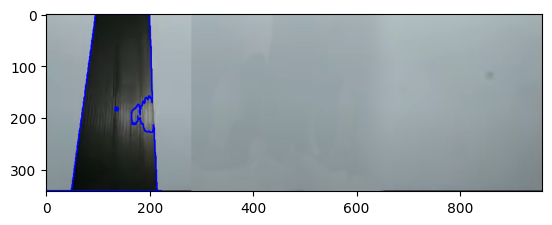

In [67]:
im_left = cv2.imread("line_left.png")
im_proc = process_image(im_left)
plt.imshow(im_proc)

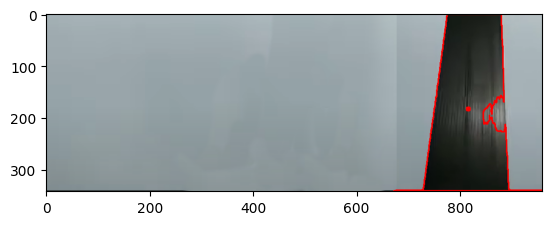

In [68]:
im_right = cv2.imread("line_right.png")
im_proc = process_image(im_right)
plt.imshow(im_proc)